In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import hog
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
data = pd.read_csv('emnist-letters-train.csv')

In [ ]:
data.shape

(88799, 785)

In [ ]:
#Memisahkan fitur dan label
X_all = data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')
y_all = data.iloc[:, 0].values.astype('int')

In [ ]:
#Batas max sample
max_samples_per_class = 100
X_selected = []
y_selected = []

for label in np.unique(y_all):
    idx = np.where(y_all == label)[0][:max_samples_per_class]
    X_selected.append(X_all[idx])
    y_selected.append(y_all[idx])

X_selected = np.concatenate(X_selected)
y_selected = np.concatenate(y_selected)

In [ ]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, stratify=y_selected, random_state=42)

In [ ]:
# Ekstraksi HOG - Train
hog_features_train = []
hog_images_train = []
for train_image in X_train:
    feature, hog_img = hog(train_image.reshape(28,28),
                           orientations=10, #9
                           pixels_per_cell=(4, 4), #(8, 8)
                           cells_per_block=(4, 4), #(2, 2)
                           visualize=True, block_norm='L2')
    hog_features_train.append(feature)
    hog_images_train.append(hog_img)

hog_features_train_np = np.array(hog_features_train)

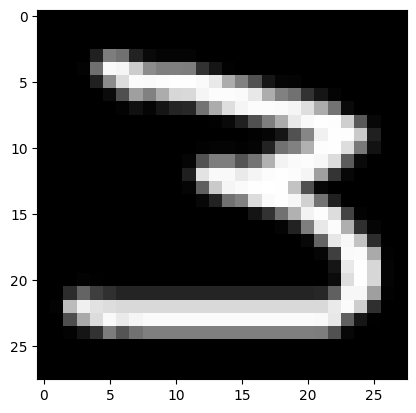

In [ ]:
plt.imshow(X_train[3].reshape(28,28), cmap='gray')

In [ ]:
label_map = {i: chr(64+i) for i in range(1, 27)}  # 1->A, ..., 26->Z
label_num = y_test[3]
label_letter = label_map.get(label_num, '?')
print(f"{label_num} ({label_letter})")


23 (W)


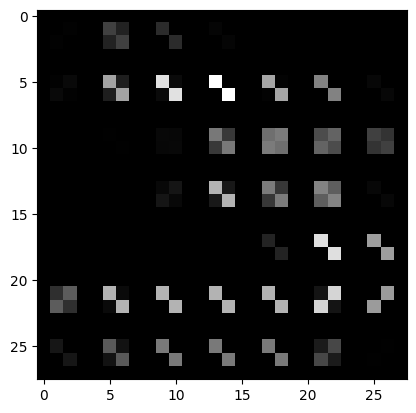

In [ ]:
plt.imshow(hog_images_train[3].reshape(28,28), cmap='gray')

In [ ]:
# Ekstraksi HOG - Test
hog_features_test = []
hog_images_test = []
for test_image in X_test:
    feature, hog_img = hog(test_image.reshape(28,28),
                           orientations=10, #9
                           pixels_per_cell=(4, 4), #(8, 8)
                           cells_per_block=(4, 4),#(2, 2),
                           visualize=True, block_norm='L2')
    hog_features_test.append(feature)
    hog_images_test.append(hog_img)

hog_features_test_np = np.array(hog_features_test)


In [ ]:
# Standardisasi fitur
scaler = StandardScaler()
hog_features_train_scaled = scaler.fit_transform(hog_features_train_np)
hog_features_test_scaled = scaler.transform(hog_features_test_np)

In [ ]:
# Grid search parameter SVM
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'degree': [2, 3]
}

svc = svm.SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(hog_features_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3],
                         'gamma': ['scale', 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [ ]:
print("\nBest parameters found by Grid Search:")
print(grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Best parameters found by Grid Search:
{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.7961538461538462


In [ ]:
# Evaluasi dengan LOOCV menggunakan parameter terbaik
best_svc = grid_search.best_estimator_
y_pred_loo = cross_val_predict(best_svc, hog_features_train_scaled, y_train, cv=LeaveOneOut())

In [ ]:
# Hitung metrik
loo_confusion_matrix = confusion_matrix(y_train, y_pred_loo)
loo_accuracy = accuracy_score(y_train, y_pred_loo)
loo_precision = precision_score(y_train, y_pred_loo, average='macro')
loo_recall = recall_score(y_train, y_pred_loo, average='macro')
loo_f1 = f1_score(y_train, y_pred_loo, average='macro')

In [ ]:
# Cetak hasil
print("\nLOOCV Results (Training Data):")
print("Confusion Matrix:")
print(loo_confusion_matrix)
print("Accuracy:", loo_accuracy)
print("Precision:", loo_precision)
print("Recall:", loo_recall)
print("F1 Score:", loo_f1)


LOOCV Results (Training Data):
Confusion Matrix:
[[56  0  1  1  1  2  2  1  0  0  0  0  0  3  2  2  4  0  0  1  0  0  1  0
   0  3]
 [ 2 65  0  2  0  1  3  2  0  1  2  0  0  0  1  1  0  0  0  0  0  0  0  0
   0  0]
 [ 2  0 66  0  6  0  4  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0
   0  0]
 [ 2  1  0 66  0  0  0  0  1  3  0  0  1  0  2  0  0  0  1  2  0  0  0  0
   0  1]
 [ 0  0  8  0 65  2  1  0  0  0  0  0  0  0  0  1  0  2  0  1  0  0  0  0
   0  0]
 [ 0  0  0  0  1 66  0  0  1  0  0  2  0  0  0  2  0  1  0  6  0  0  0  0
   0  1]
 [ 1  4  2  0  1  1 52  0  2  1  0  0  0  1  0  1 12  0  1  1  0  0  0  0
   0  0]
 [ 2  0  0  0  0  0  0 72  0  0  2  0  1  0  0  0  0  1  0  1  1  0  0  0
   0  0]
 [ 1  1  0  1  0  0  0  0 50  2  0 21  0  0  0  0  0  1  0  1  0  0  0  2
   0  0]
 [ 0  0  0  2  0  0  0  0  3 68  0  1  0  0  0  0  0  0  1  4  0  1  0  0
   0  0]
 [ 0  1  0  0  1  1  0  2  0  0 68  1  0  1  0  0  0  2  0  1  0  2  0  0
   0  0]
 [ 0  0  4  0  0  1  0  0 18  0  2 54

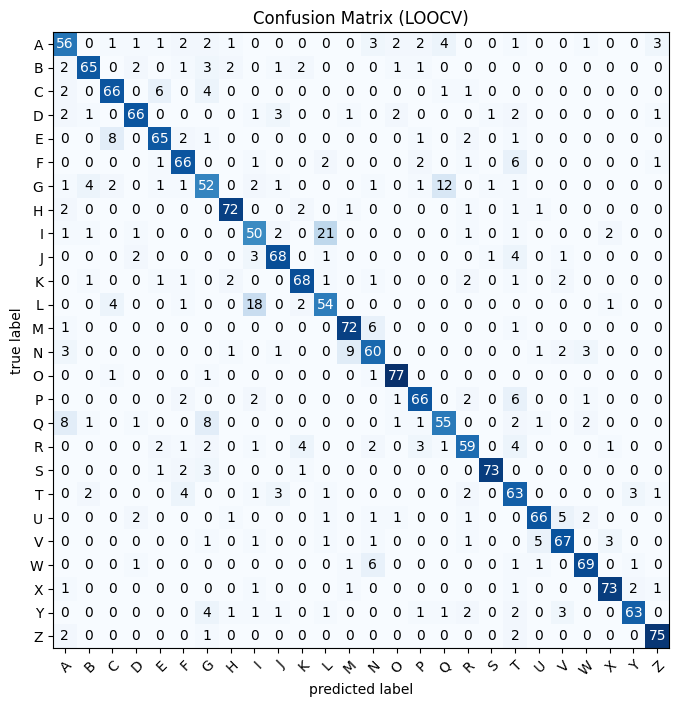

In [ ]:
class_labels =['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                'U', 'V', 'W', 'X', 'Y', 'Z']
#plot_confusion_matrix(loo_confusion_matrix)
plot_confusion_matrix(conf_mat=loo_confusion_matrix,
                      class_names=class_labels,
                      figsize=(8, 8),
                      cmap='Blues')
plt.title('Confusion Matrix (LOOCV)')
plt.show()


In [ ]:
# Evaluasi Test Data
best_svc.fit(hog_features_train_scaled, y_train)
y_test_pred = best_svc.predict(hog_features_test_scaled)

In [ ]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')
test_cm = confusion_matrix(y_test, y_test_pred)

print("\n[Evaluation on Test Data (20%)]")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)


[Evaluation on Test Data (20%)]
Accuracy: 0.8134615384615385
Precision: 0.8214854376004935
Recall: 0.8134615384615386
F1 Score: 0.8124699813367212


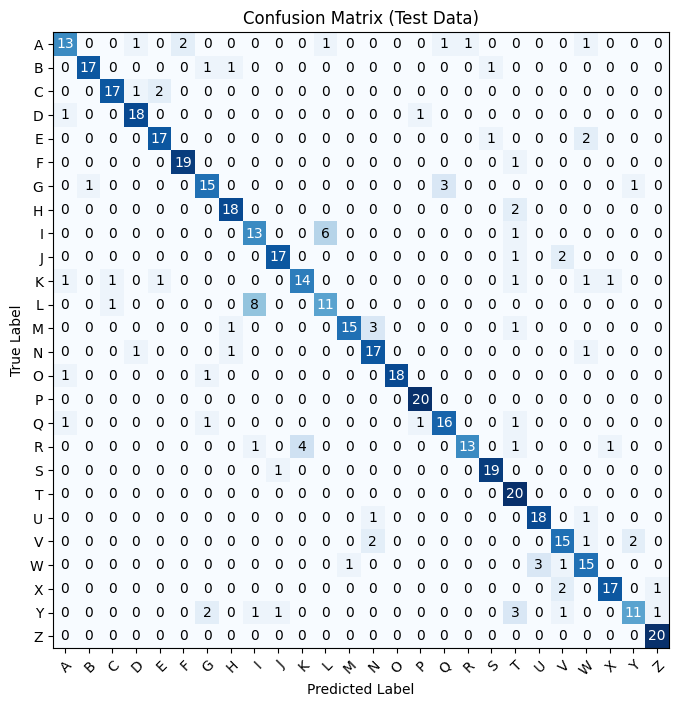

In [ ]:
class_labels =['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                'U', 'V', 'W', 'X', 'Y', 'Z']
def plot_confusion_mat(cm, title):
    plot_confusion_matrix(conf_mat=cm, class_names=class_labels,
                      figsize=(8, 8), cmap=plt.cm.Blues)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_mat(test_cm, title='Confusion Matrix (Test Data)')

In [ ]:
image=X_test

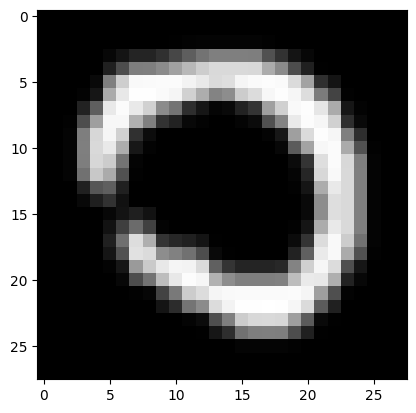

In [ ]:

plt.imshow(image[21].reshape(28, 28), cmap='gray')

In [ ]:
label_map = {i: chr(64+i) for i in range(1, 27)}  # 1->A, 2->B, ..., 26->Z
true_label_num = y_test[21]
true_label_letter = label_map.get(true_label_num, '?')
print(f"True Label: {true_label_num} ({true_label_letter})")

True Label: 15 (O)


In [ ]:
def plot_images_with_hog(X, hog_images, title=""):
    fig, axes = plt.subplots(2, 10, figsize=(15, 5))
    fig.suptitle(title)

    for i in range(min(len(X), 10)):
        axes[0, i].imshow(X[i].reshape((28, 28)), cmap='gray')
        axes[0, i].axis('off')

    for i in range(min(len(hog_images), 10)):
        axes[1, i].imshow(hog_images[i].reshape((28, 28)), cmap='gray')
        axes[1, i].axis('off')

    plt.show()



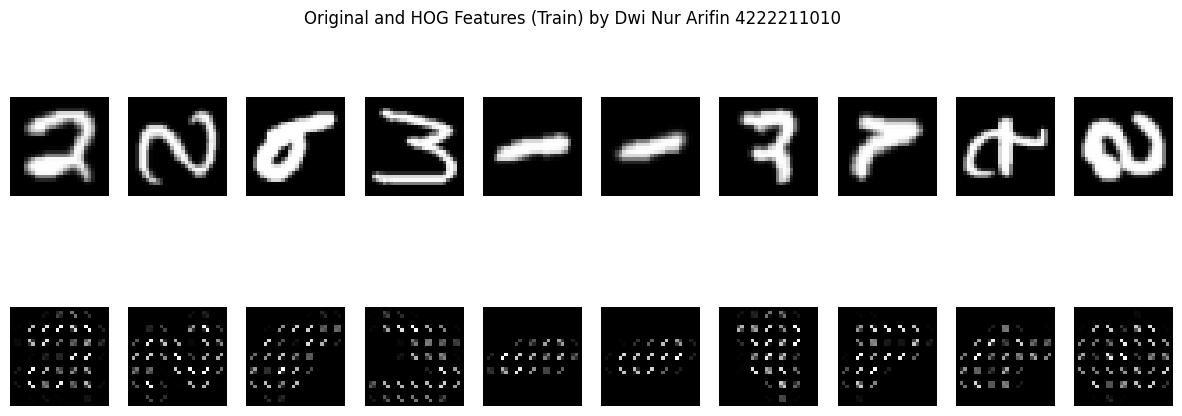

In [ ]:
plot_images_with_hog(X_train, hog_images_train, title='Original and HOG Features (Train) by Dwi Nur Arifin 4222211010')